# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
%pylab inline
import os.path
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

Populating the interactive namespace from numpy and matplotlib


## Retrieving  the nz data

In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

Text(0.5, 0, 'z')

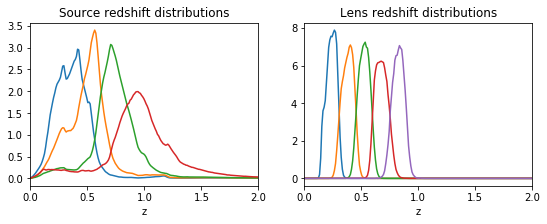

In [3]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')
subplot(122)
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,2);
title('Lens redshift distributions');
xlabel('z')

In [4]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(0, 1)

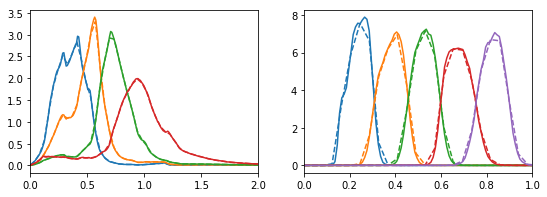

In [5]:
z = linspace(0,2)
figure(figsize=(9,3))
subplot(121)

for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)
subplot(122)

for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_l[i](z), '--', color='C%d'%i)
xlim(0,1)

##  Let's build  a model for C_ell

In [6]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [1.0, 2.0, 3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [DeviceArray(1., dtype=float32), DeviceArray(2., dtype=float32)])

In [7]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in 
         [1.4, 1.6, 1.6, 1.9, 2.0]] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [8]:
# Let's try it out
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.)

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.])

In [9]:
cl_3x2pt = mu(fid_params)

/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [10]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in 
         [1.4, 1.6, 1.6, 1.9, 2.0]] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25)
    
    return cov

In [11]:
C = cov(fid_params)

In [12]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [13]:
j = jacobian(fid_params)

In [14]:
import scipy

def symmetrized_matrix(U):
    u"""Return a new matrix like `U`, but with upper-triangle elements copied to lower-triangle ones."""
    M = U.copy()
    inds = onp.triu_indices_from(M,k=1)
    M[(inds[1], inds[0])] = M[inds]
    return M



def symmetric_positive_definite_inverse(M):
    u"""Compute the inverse of a symmetric positive definite matrix `M`.

    A :class:`ValueError` will be thrown if the computation cannot be
    completed.

    """
    import scipy.linalg
    U,status = scipy.linalg.lapack.dpotrf(M)
    if status != 0:
        raise ValueError("Non-symmetric positive definite matrix")
    M,status = scipy.linalg.lapack.dpotri(U)
    if status != 0:
        raise ValueError("Error in Cholesky factorization")
    M = symmetrized_matrix(M)
    return M

In [15]:
j64 = onp.array(j).astype(onp.float64)
C64 = onp.array(C).astype(onp.float64)

In [16]:
# And we get the fisher matrix from the jacobian and covariance
CC = symmetric_positive_definite_inverse(C64)
F = onp.einsum('ia,ij,jb->ab', j64, CC, j64)
F = 0.5*(F + F.T)

In [17]:
def is_symmetric(X):
    return onp.all(X == X.T)

is_symmetric(F)

True

In [94]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(i)
  s2 = 1.5*nstd*sigma_marg(j)
#   ax.set_xlim(pos[i] - s1, pos[i] + s1)
#   ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

(0.2, 0.4)

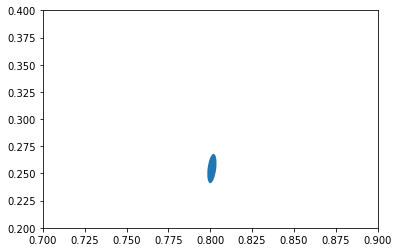

In [113]:
plot_contours(F, fid_params, 0, 1)
xlim(0.7, 0.9)
ylim(0.2, 0.4)

In [20]:
# parameter inverse mass matrix
M_inv = symmetric_positive_definite_inverse(F)
is_symmetric(M_inv)

True

In [21]:
#priors - index, mean, std. dev
prior_values = [
    (6, 0.012, 0.023),  #m1
    (7, 0.012, 0.023),  #m2
    (8, 0.012, 0.023),  #m3
    (9, 0.012, 0.023),  #m4
    (10, -0.001, 0.016),   #dz1
    (11, -0.019, 0.013),   #dz2
    (12,0.009, 0.011),   #dz3
    (13, -0.018, 0.022),   #dz4
]

In [118]:
def priors(p):
    logpi = 0.0
    dlogpi_dp = onp.zeros_like(p)
    for i, mu_i, sigma_i in prior_values:
        logpi += -0.5 * (p[i] - mu_i)**2 / sigma_i**2
        dlogpi_dp[i] = - (p[i] - mu_i) / sigma_i**2
    return logpi, dlogpi_dp

# returns -posterior P and -dL/dP
def fun(p, inv_cov=C, data=cl_3x2pt.flatten()):
    # theory C_ell prediction
    cl = mu(p).flatten()
    # d C_ell / d p
    j = jacobian(p).T
    d = cl - data
    dlogL_dCl = -inv_cov @ d
    logL = 0.5 * d @ dlogL_dCl
    dlogL_dp = j @ dlogL_dCl
    
    # Add Gaussian priors.
    # Can't use += because of JAX
    logPi, dlogPi_dp = priors(p)
    P = logL + logPi
    dP_dp = dlogL_dp + dlogPi_dp

    # convert back to regular numpy arrays
    return onp.array(P), onp.array(dP_dp)


In [26]:
import hmc

limits = [
    (0.5, 0.9), # sigma8
    (0.1, 0.5), # Omega_c
    (0.03, 0.06), # Omega_b
    (0.5,  0.9), # h
    (0.9,  1.05), # n_s
    (-2.0,  -0.5), # w0
    (-0.06, 0.06), #m1
    (-0.06, 0.06), #m2
    (-0.06, 0.06), #m3
    (-0.06, 0.06), #m4
    (-0.1, 0.1), #dz1
    (-0.1, 0.1), #dz2
    (-0.1, 0.1), #dz3
    (-0.1, 0.1), #dz4
    (0.0, 3.0),  #A
    (-3., 3.), #eta
]
data = onp.array(cl_3x2pt.flatten())
Cinv = onp.linalg.inv(C)
epsilon = 0.05 # time step
steps_per_iteration = 20
fun_kwargs = {'inv_cov': Cinv, 'data': data} 
sampler = hmc.HMC(fun, M_inv, epsilon, steps_per_iteration, limits, kwargs=fun_kwargs)
n_it = 100
sampler.sample(n_it, fid_params)

U=2.394   T=11.563   H=13.957
U=2.561   T=11.395   H=13.956
U=2.801   T=11.159   H=13.959
U=3.113   T=10.846   H=13.959
U=3.515   T=10.449   H=13.964
U=3.999   T=9.965   H=13.964
U=4.570   T=9.396   H=13.967
U=5.229   T=8.751   H=13.980
U=5.944   T=8.042   H=13.986
U=6.695   T=7.293   H=13.988
U=7.511   T=6.526   H=14.036
U=8.268   T=5.769   H=14.037
U=9.007   T=5.054   H=14.061
U=9.672   T=4.405   H=14.077
U=10.235   T=3.843   H=14.078
U=10.698   T=3.380   H=14.078
U=11.086   T=3.018   H=14.103
U=11.364   T=2.750   H=14.113
U=11.559   T=2.561   H=14.121
U=11.722   T=2.434   H=14.155
Accept 0 alpha=0.82  p=0.23
U=11.793   T=7.170   H=18.963
U=11.818   T=7.123   H=18.941
U=11.808   T=7.127   H=18.935
U=11.745   T=7.192   H=18.937
U=11.615   T=7.322   H=18.937
U=11.422   T=7.514   H=18.935
U=11.174   T=7.759   H=18.933
U=10.888   T=8.045   H=18.933
U=10.556   T=8.356   H=18.912
U=10.225   T=8.675   H=18.899
U=9.914   T=8.984   H=18.898
U=9.625   T=9.271   H=18.896
U=9.375   T=9.523   H=1

U=8.742   T=9.920   H=18.662
Accept 12 alpha=0.94  p=0.29
U=8.605   T=5.311   H=13.916
U=8.426   T=5.492   H=13.918
U=8.220   T=5.698   H=13.918
U=8.001   T=5.917   H=13.918
U=7.772   T=6.134   H=13.906
U=7.555   T=6.337   H=13.893
U=7.358   T=6.516   H=13.875
U=7.203   T=6.665   H=13.868
U=7.078   T=6.780   H=13.858
U=6.995   T=6.860   H=13.855
U=6.940   T=6.908   H=13.849
U=6.914   T=6.928   H=13.842
U=6.911   T=6.925   H=13.836
U=6.929   T=6.905   H=13.834
U=6.953   T=6.875   H=13.828
U=6.987   T=6.841   H=13.828
U=7.014   T=6.808   H=13.822
U=7.039   T=6.780   H=13.819
U=7.059   T=6.757   H=13.815
U=7.077   T=6.738   H=13.815
Accept 13 alpha=1.10  p=0.09
U=6.629   T=7.623   H=14.252
U=6.198   T=8.047   H=14.245
U=5.827   T=8.432   H=14.259
U=5.488   T=8.764   H=14.252
U=5.209   T=9.031   H=14.240
U=5.022   T=9.224   H=14.246
U=4.907   T=9.337   H=14.244
U=4.876   T=9.371   H=14.248
U=4.927   T=9.330   H=14.257
U=5.034   T=9.221   H=14.255
U=5.201   T=9.056   H=14.257
U=5.409   T=8.

U=11.534   T=9.647   H=21.181
Accept 25 alpha=1.06  p=0.06
U=11.358   T=7.750   H=19.107
U=11.153   T=7.955   H=19.108
U=10.889   T=8.219   H=19.108
U=10.567   T=8.541   H=19.108
U=10.177   T=8.909   H=19.086
U=9.784   T=9.308   H=19.092
U=9.350   T=9.718   H=19.068
U=8.947   T=10.118   H=19.065
U=8.561   T=10.491   H=19.052
U=8.182   T=10.818   H=19.000
U=7.919   T=11.084   H=19.003
U=7.727   T=11.279   H=19.006
U=7.622   T=11.394   H=19.016
U=7.600   T=11.428   H=19.028
U=7.656   T=11.381   H=19.038
U=7.759   T=11.261   H=19.020
U=7.944   T=11.076   H=19.020
U=8.181   T=10.841   H=19.023
U=8.418   T=10.577   H=18.995
U=8.684   T=10.306   H=18.990
Accept 26 alpha=1.15  p=0.93
U=8.386   T=12.841   H=21.227
U=8.149   T=13.078   H=21.226
U=8.036   T=13.226   H=21.262
U=7.985   T=13.277   H=21.261
U=8.034   T=13.230   H=21.264
U=8.171   T=13.096   H=21.267
U=8.395   T=12.897   H=21.291
U=8.647   T=12.661   H=21.308
U=8.888   T=12.420   H=21.309
U=9.102   T=12.209   H=21.310
U=9.258   T=12

U=8.428   T=13.670   H=22.098
U=7.883   T=14.157   H=22.040
U=7.570   T=14.458   H=22.028
U=7.465   T=14.562   H=22.027
U=7.552   T=14.477   H=22.029
U=7.806   T=14.226   H=22.032
U=8.187   T=13.847   H=22.034
U=8.651   T=13.389   H=22.039
U=9.140   T=12.901   H=22.041
U=9.614   T=12.432   H=22.046
U=10.028   T=12.020   H=22.048
U=10.361   T=11.692   H=22.054
U=10.595   T=11.463   H=22.058
U=10.728   T=11.328   H=22.056
U=10.783   T=11.271   H=22.055
U=10.778   T=11.267   H=22.045
U=10.755   T=11.284   H=22.039
U=10.748   T=11.288   H=22.037
Accept 39 alpha=1.12  p=0.03
U=10.586   T=6.379   H=16.966
U=10.410   T=6.563   H=16.974
U=10.218   T=6.754   H=16.973
U=10.030   T=6.942   H=16.972
U=9.853   T=7.120   H=16.972
U=9.688   T=7.285   H=16.972
U=9.534   T=7.438   H=16.972
U=9.387   T=7.585   H=16.973
U=9.247   T=7.732   H=16.979
U=9.096   T=7.885   H=16.981
U=8.938   T=8.050   H=16.989
U=8.763   T=8.231   H=16.993
U=8.571   T=8.423   H=16.994
U=8.375   T=8.620   H=16.995
U=8.186   T=8

U=7.520   T=6.714   H=14.234
U=7.525   T=6.725   H=14.249
U=7.488   T=6.770   H=14.258
U=7.407   T=6.852   H=14.260
U=7.302   T=6.968   H=14.269
U=7.174   T=7.106   H=14.280
U=7.035   T=7.255   H=14.290
U=6.891   T=7.396   H=14.287
U=6.784   T=7.511   H=14.296
U=6.744   T=7.585   H=14.329
U=6.746   T=7.604   H=14.350
U=6.815   T=7.562   H=14.377
U=6.938   T=7.458   H=14.396
U=7.132   T=7.299   H=14.432
Accept 52 alpha=0.79  p=0.30
U=6.995   T=9.795   H=16.790
U=6.922   T=9.868   H=16.790
U=6.834   T=9.925   H=16.759
U=6.774   T=9.963   H=16.736
U=6.719   T=9.975   H=16.694
U=6.736   T=9.958   H=16.693
U=6.769   T=9.910   H=16.679
U=6.815   T=9.832   H=16.647
U=6.921   T=9.725   H=16.646
U=7.038   T=9.591   H=16.629
U=7.183   T=9.435   H=16.618
U=7.345   T=9.262   H=16.607
U=7.497   T=9.077   H=16.575
U=7.679   T=8.886   H=16.565
U=7.873   T=8.692   H=16.564
U=8.025   T=8.498   H=16.523
U=8.213   T=8.305   H=16.518
U=8.377   T=8.113   H=16.490
U=8.526   T=7.919   H=16.445
U=8.716   T=7.

U=6.755   T=8.018   H=14.773
U=6.427   T=8.335   H=14.762
U=6.132   T=8.629   H=14.761
U=5.887   T=8.872   H=14.760
U=5.646   T=9.040   H=14.687
U=5.570   T=9.118   H=14.688
Accept 65 alpha=1.11  p=0.83
U=5.663   T=14.238   H=19.901
U=5.847   T=14.055   H=19.902
U=6.091   T=13.800   H=19.892
U=6.381   T=13.495   H=19.876
U=6.712   T=13.162   H=19.874
U=7.046   T=12.826   H=19.872
U=7.357   T=12.502   H=19.859
U=7.656   T=12.203   H=19.858
U=7.923   T=11.933   H=19.856
U=8.157   T=11.689   H=19.846
U=8.377   T=11.463   H=19.840
U=8.629   T=11.237   H=19.867
U=8.877   T=10.994   H=19.872
U=9.130   T=10.721   H=19.851
U=9.436   T=10.401   H=19.838
U=9.840   T=10.026   H=19.866
U=10.261   T=9.590   H=19.851
U=10.746   T=9.098   H=19.844
U=11.305   T=8.560   H=19.865
U=11.871   T=7.994   H=19.865
Accept 66 alpha=1.04  p=0.48
U=11.772   T=6.361   H=18.133
U=11.649   T=6.483   H=18.132
U=11.489   T=6.629   H=18.118
U=11.297   T=6.798   H=18.096
U=11.107   T=6.989   H=18.096
U=10.897   T=7.199

U=8.534   T=6.520   H=15.054
Accept 78 alpha=1.01  p=0.64
U=8.518   T=5.056   H=13.574
U=8.484   T=5.091   H=13.575
U=8.434   T=5.141   H=13.575
U=8.371   T=5.206   H=13.577
U=8.299   T=5.284   H=13.583
U=8.215   T=5.376   H=13.591
U=8.110   T=5.484   H=13.594
U=7.985   T=5.610   H=13.595
U=7.839   T=5.756   H=13.595
U=7.675   T=5.920   H=13.595
U=7.492   T=6.102   H=13.594
U=7.296   T=6.297   H=13.593
U=7.093   T=6.500   H=13.593
U=6.883   T=6.701   H=13.583
U=6.693   T=6.890   H=13.582
U=6.507   T=7.055   H=13.563
U=6.364   T=7.189   H=13.553
U=6.256   T=7.281   H=13.537
U=6.211   T=7.325   H=13.536
U=6.156   T=7.321   H=13.477
Accept 79 alpha=1.10  p=0.61
U=6.264   T=11.314   H=17.578
U=6.419   T=11.191   H=17.610
U=6.591   T=11.029   H=17.621
U=6.815   T=10.835   H=17.649
U=7.057   T=10.618   H=17.675
U=7.300   T=10.384   H=17.684
U=7.547   T=10.137   H=17.684
U=7.810   T=9.884   H=17.694
U=8.075   T=9.627   H=17.702
U=8.369   T=9.369   H=17.738
U=8.661   T=9.110   H=17.772
U=8.937

U=14.632   T=3.753   H=18.385
U=14.397   T=3.983   H=18.380
U=14.132   T=4.249   H=18.380
U=13.823   T=4.554   H=18.376
Accept 91 alpha=1.02  p=0.04
U=13.891   T=7.114   H=21.005
U=13.939   T=7.066   H=21.004
U=13.980   T=7.027   H=21.007
U=14.010   T=6.993   H=21.004
U=14.041   T=6.962   H=21.004
U=14.065   T=6.935   H=21.000
U=14.084   T=6.916   H=21.000
U=14.088   T=6.913   H=21.001
U=14.067   T=6.935   H=21.002
U=14.005   T=6.989   H=20.994
U=13.893   T=7.083   H=20.976
U=13.756   T=7.220   H=20.977
U=13.527   T=7.401   H=20.928
U=13.307   T=7.621   H=20.928
U=13.058   T=7.869   H=20.927
U=12.774   T=8.134   H=20.908
U=12.506   T=8.399   H=20.905
U=12.247   T=8.649   H=20.896
U=11.996   T=8.866   H=20.861
U=11.815   T=9.039   H=20.854
Accept 92 alpha=1.16  p=0.39
U=11.917   T=8.944   H=20.861
U=12.104   T=8.761   H=20.865
U=12.360   T=8.507   H=20.867
U=12.644   T=8.212   H=20.856
U=12.946   T=7.912   H=20.858
U=13.215   T=7.646   H=20.861
U=13.414   T=7.448   H=20.862
U=13.515   T

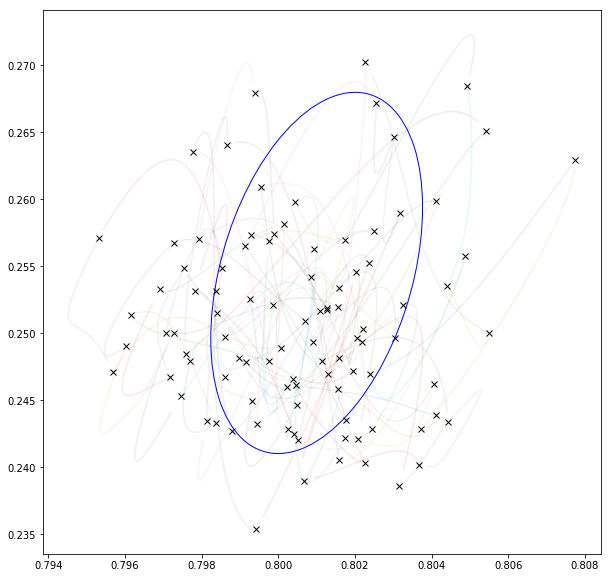

In [106]:
figure(figsize=(10,10))
i=0
j=1
plot_contours(F, fid_params, i, j, facecolor='w', edgecolor='b')
for k in range(100):
    path = onp.array(sampler.paths[k*steps_per_iteration:(k+1)*steps_per_iteration])
    if sampler.trace_accept[k]:
        plot(path[:, i], path[:, j], '-', alpha=0.1)
        plot(chain[k, i], chain[k, j], 'kx')


Text(0.5, 1.0, 'Get a load of this autocorrelation')

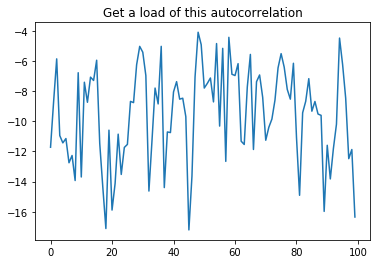

In [107]:
plot(sampler.trace_logP)
title("Get a load of this autocorrelation")

In [90]:
names = [
    "sigma8",
    "Omega_c",
    "Omega_b",
    "h",
    "n_s",
    "w0",
    "m1",
    "m2",
    "m3",
    "m4",
    "dz1",
    "dz2",
    "dz3",
    "dz4",
    "A",
    "eta",
]

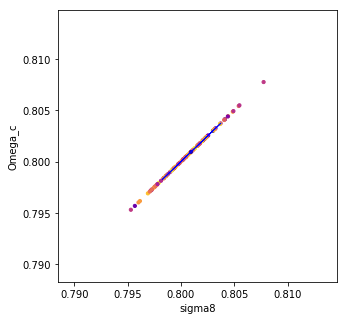

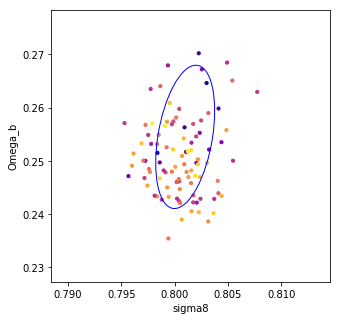

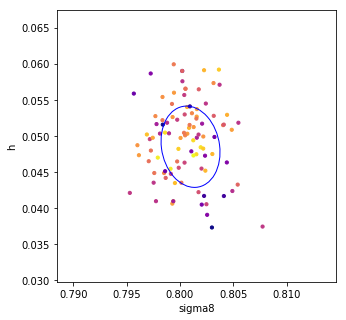

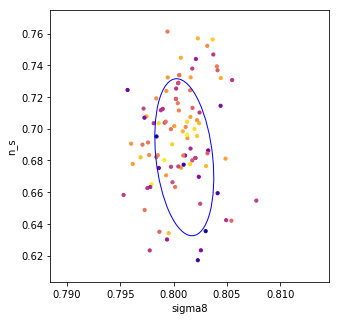

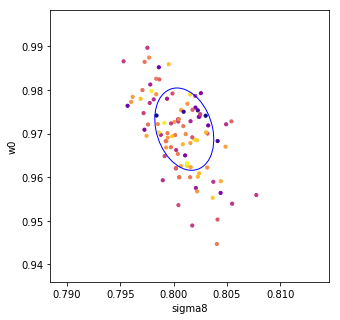

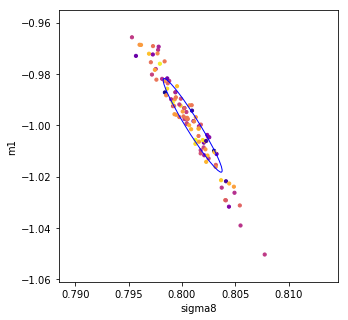

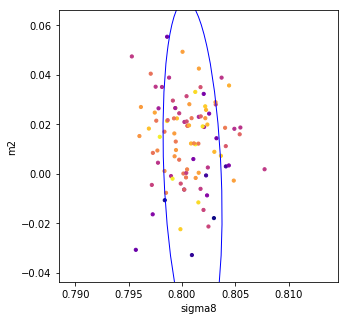

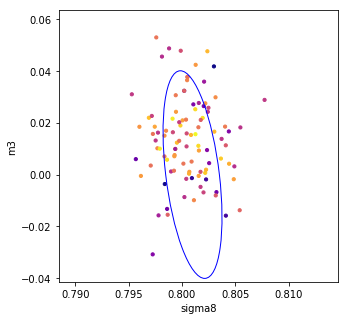

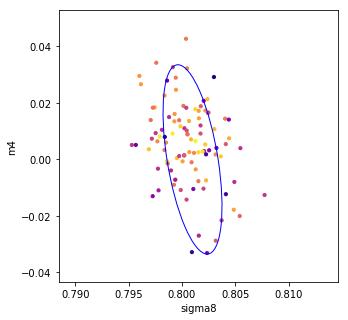

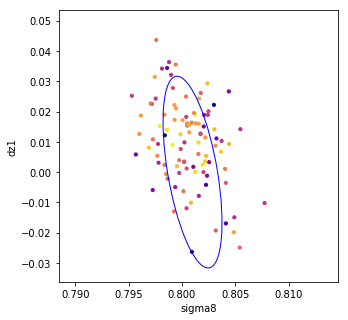

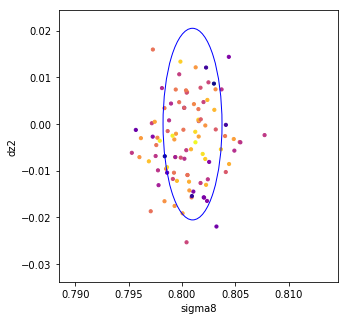

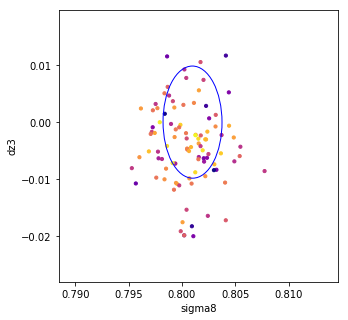

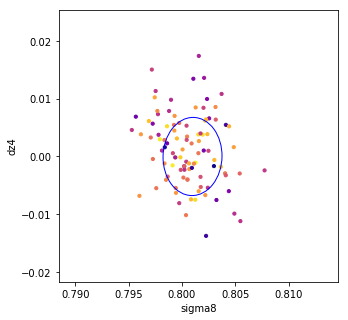

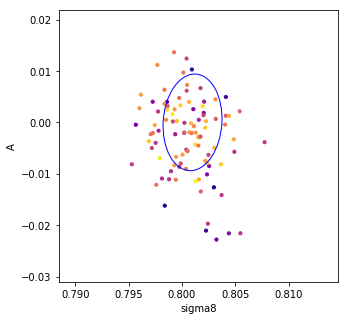

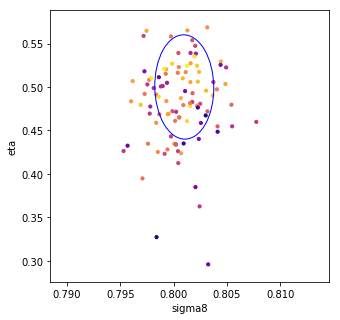

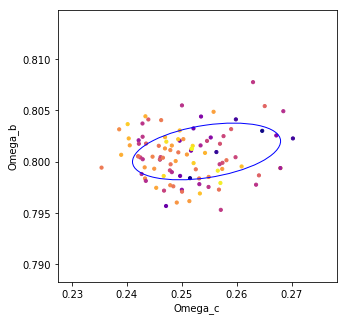

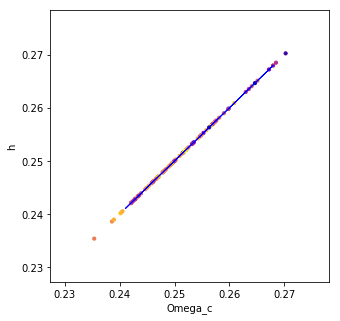

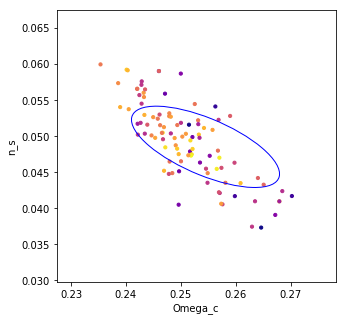

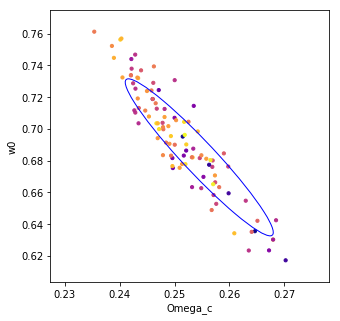

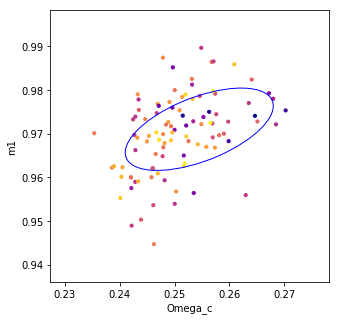

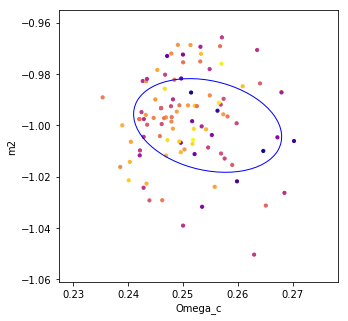

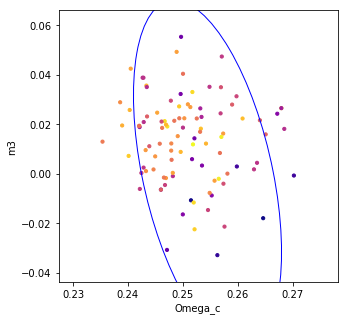

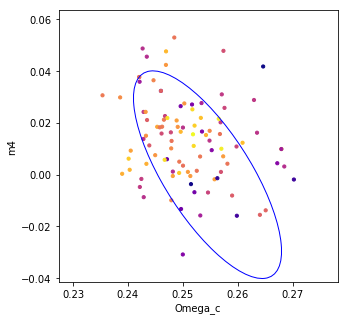

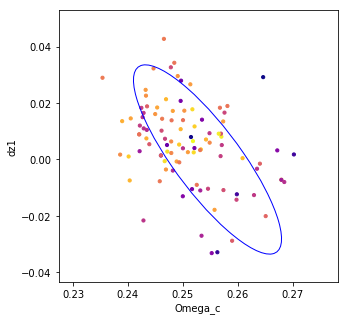

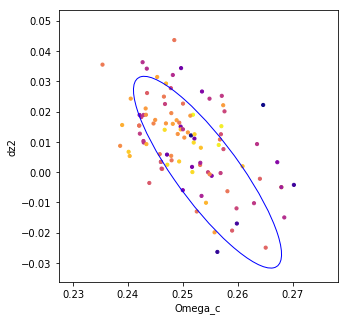

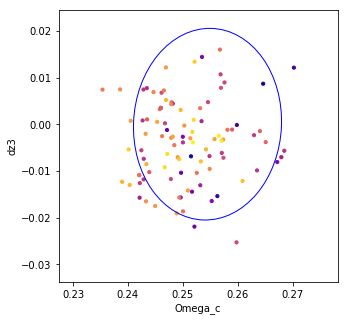

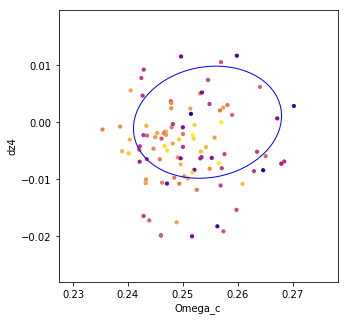

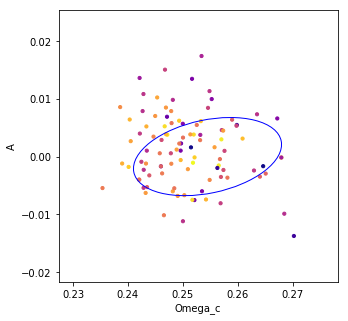

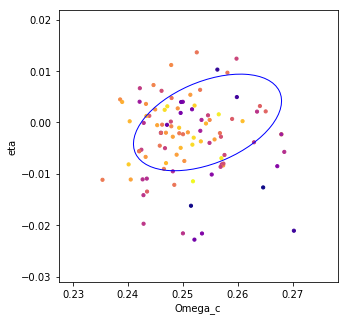

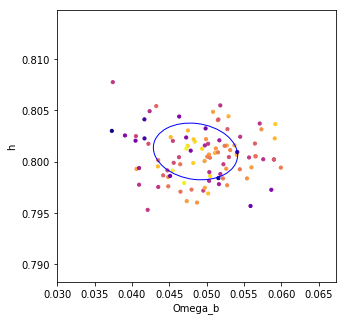

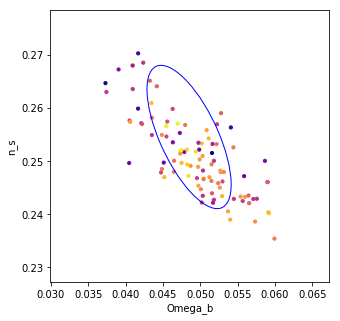

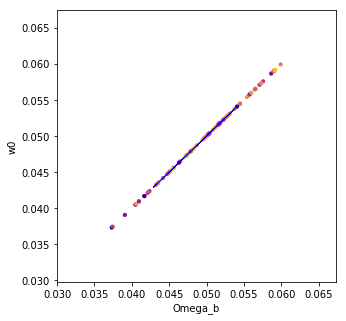

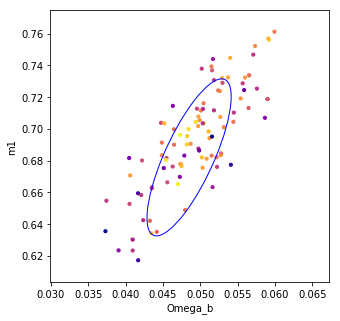

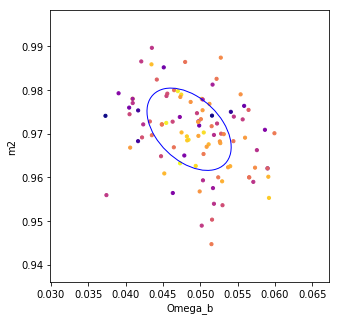

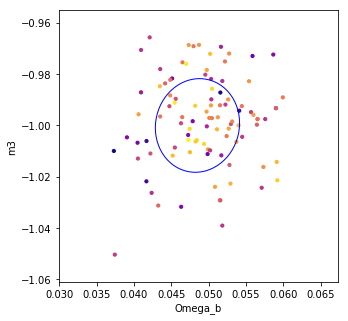

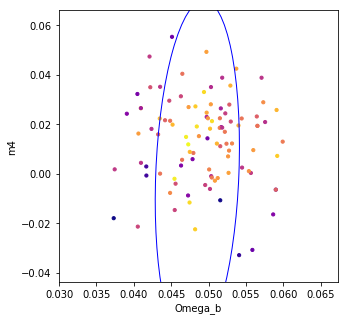

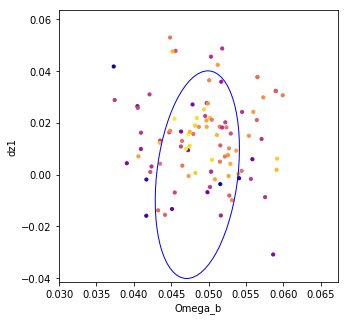

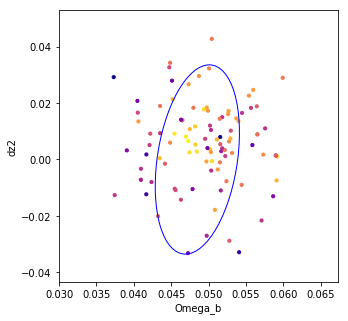

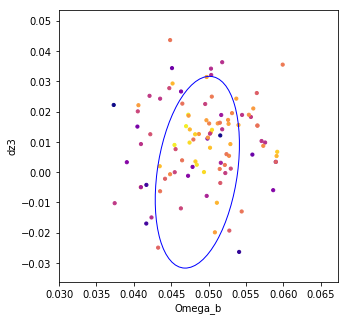

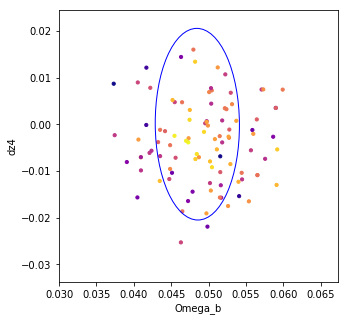

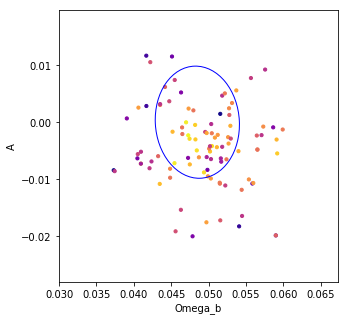

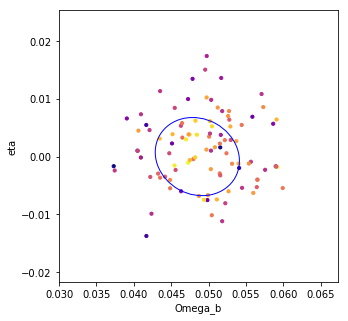

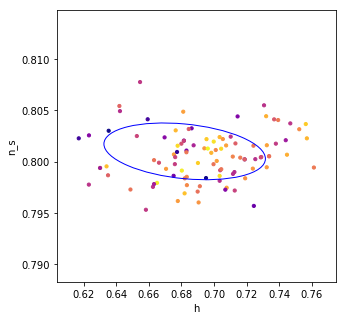

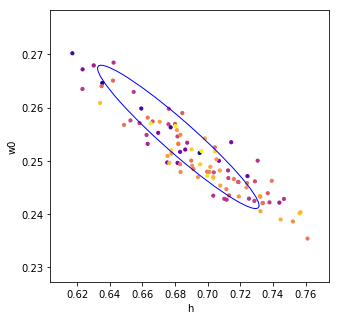

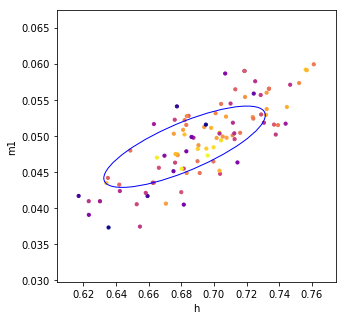

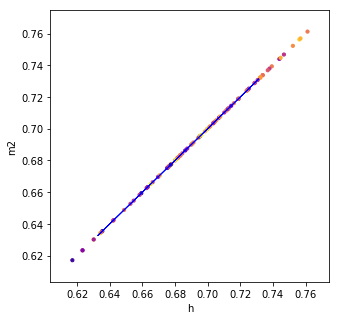

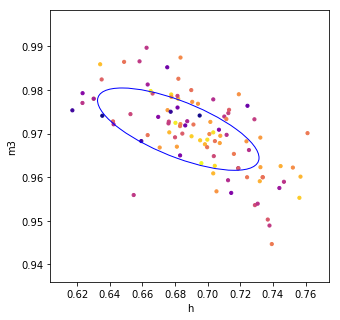

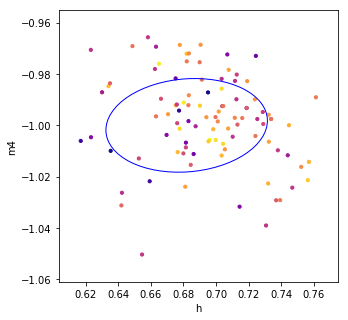

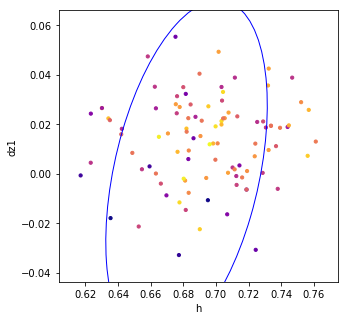

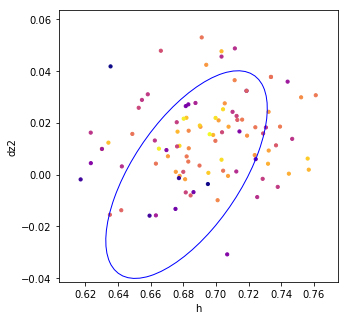

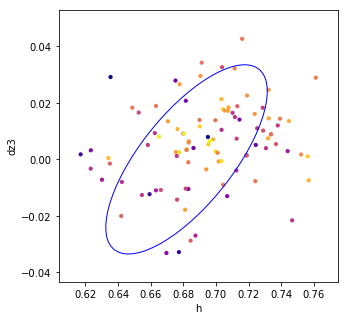

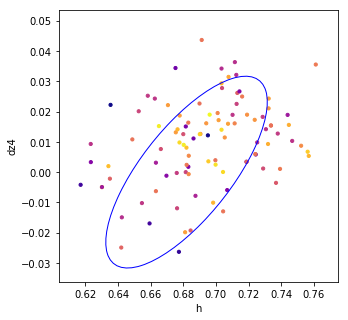

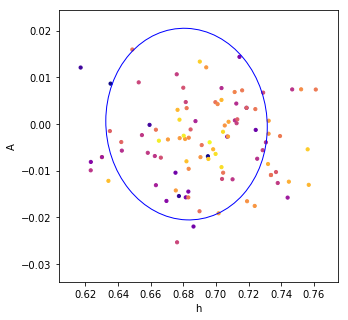

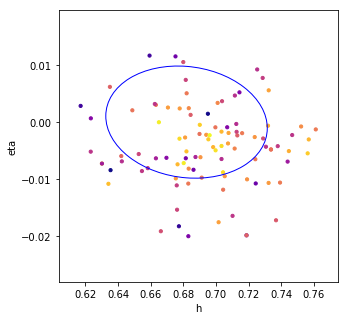

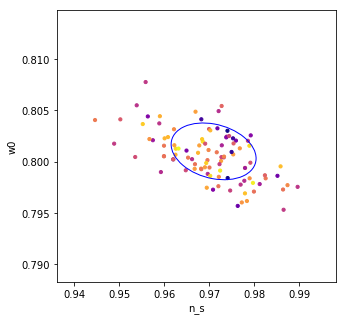

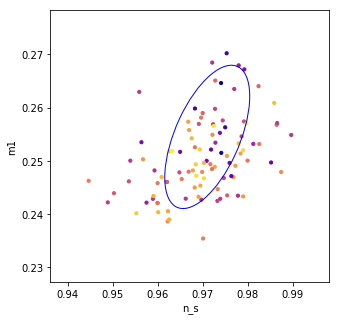

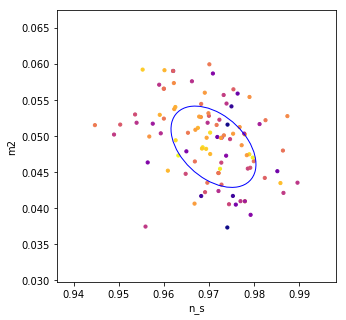

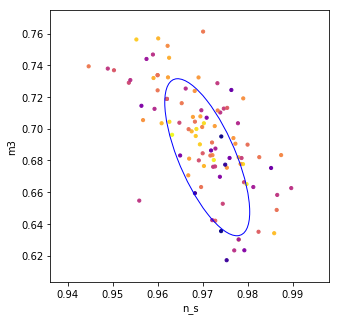

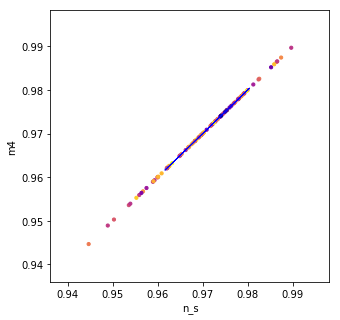

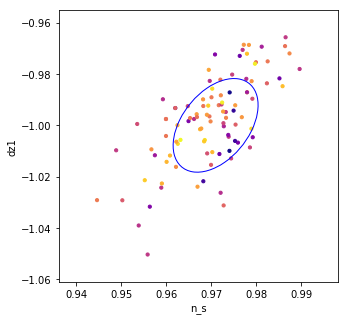

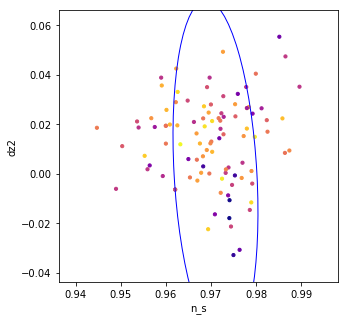

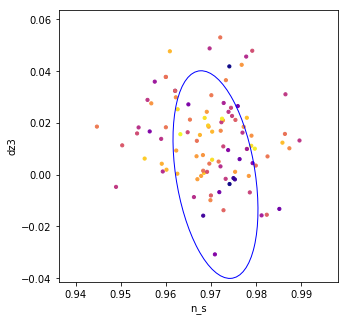

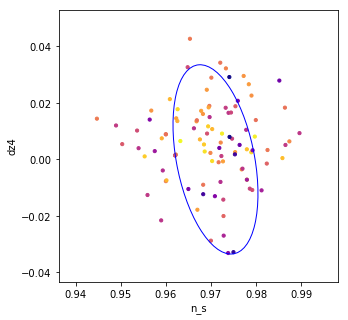

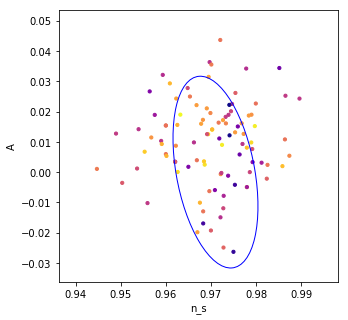

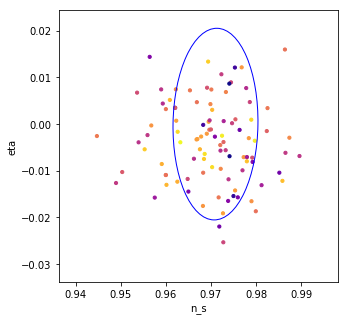

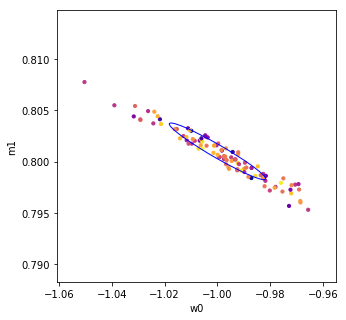

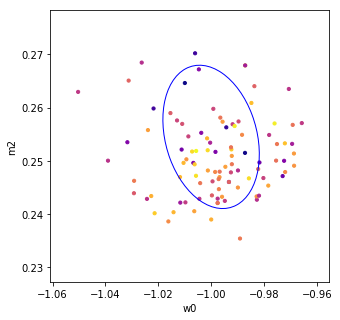

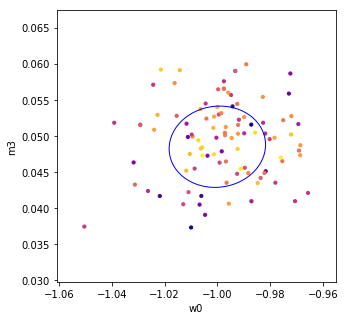

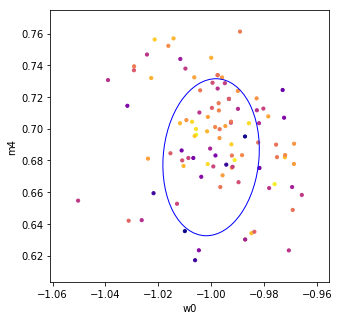

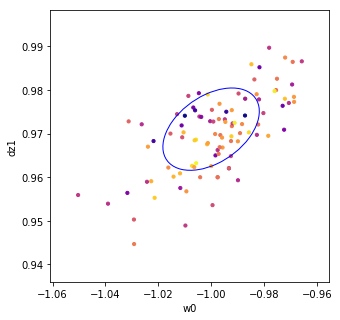

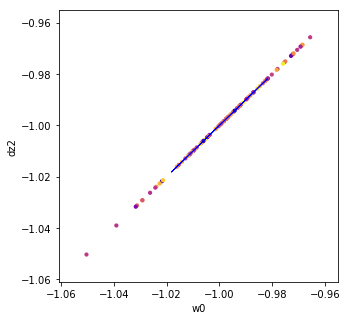

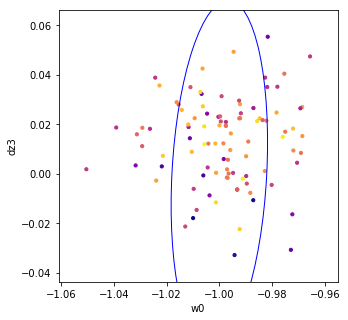

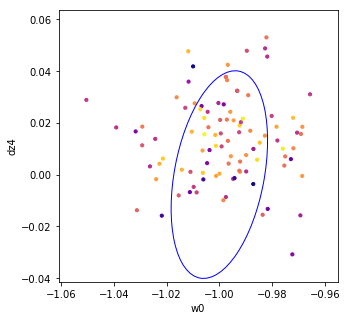

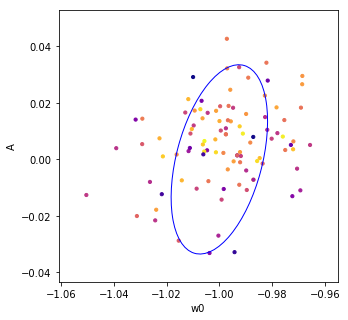

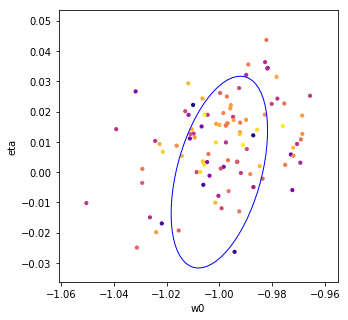

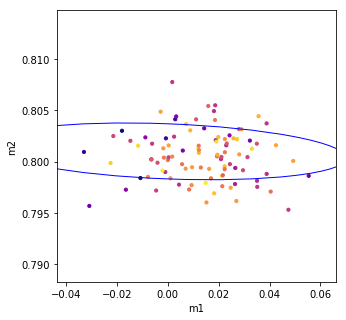

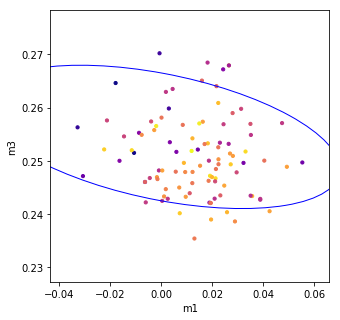

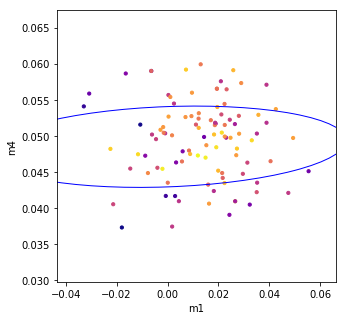

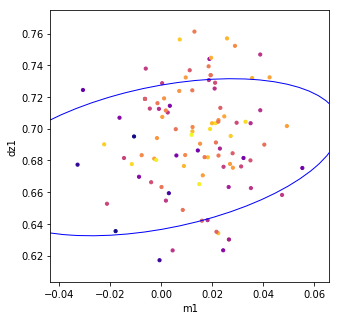

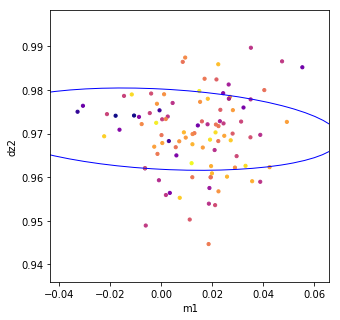

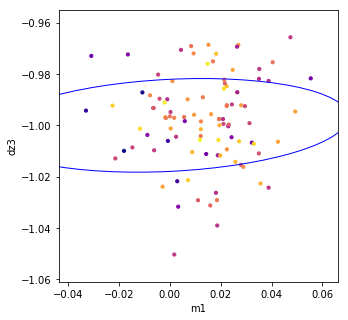

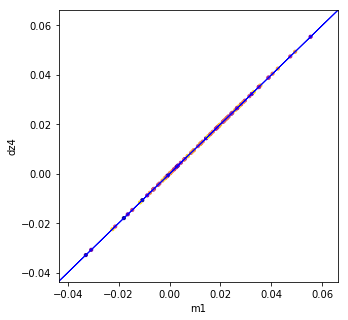

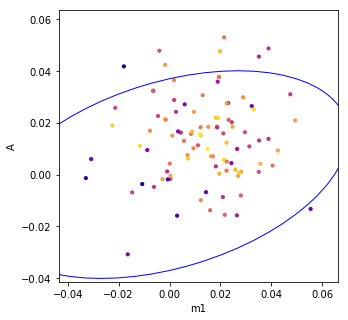

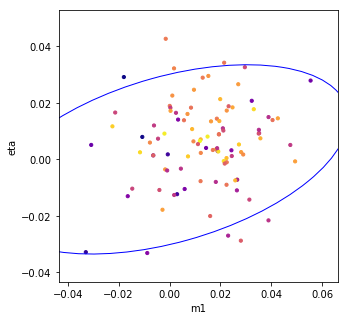

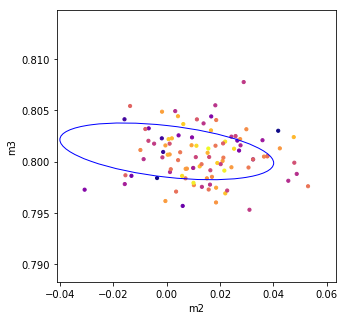

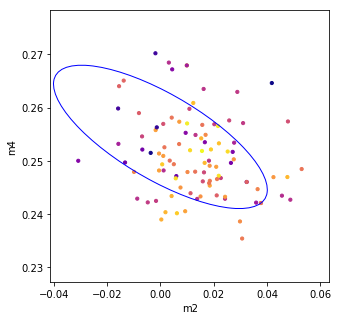

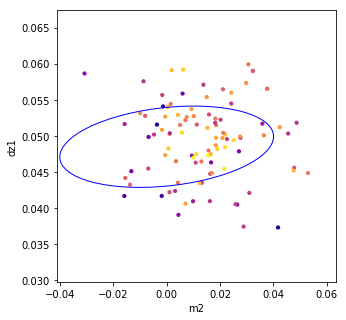

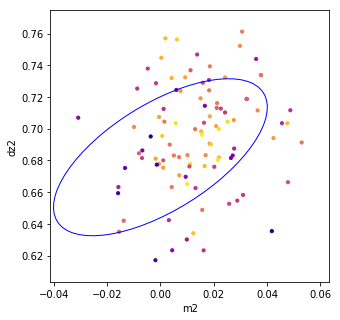

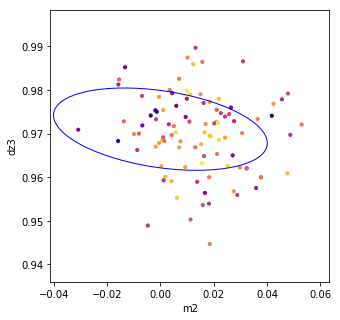

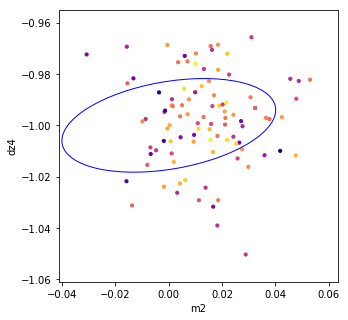

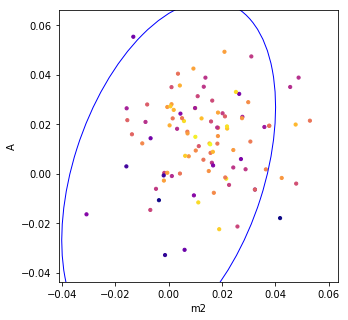

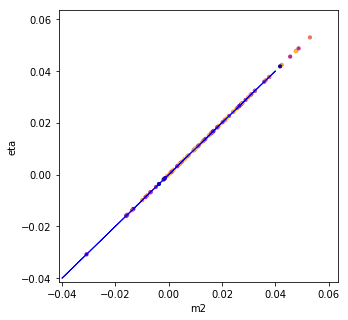

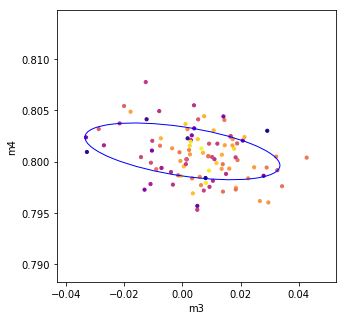

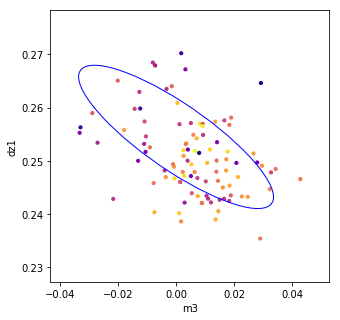

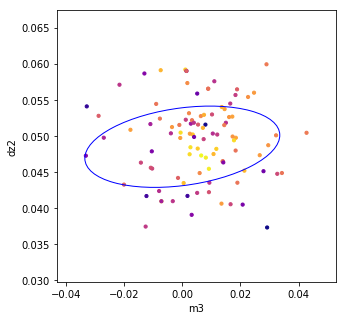

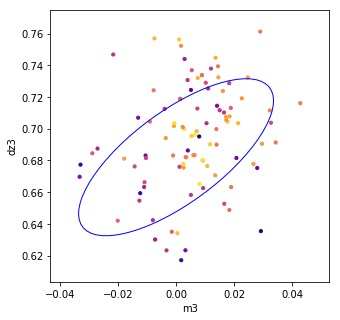

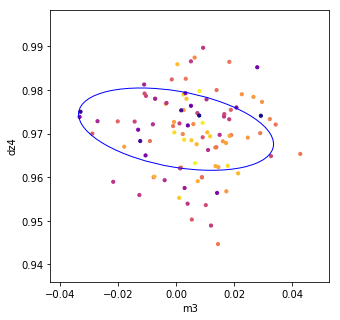

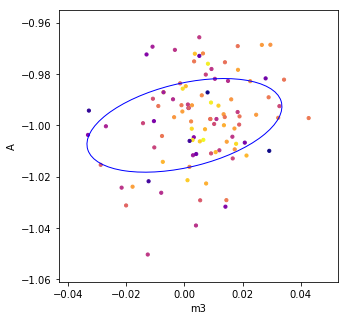

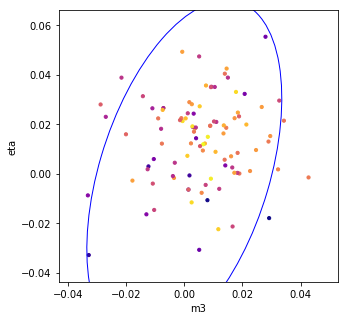

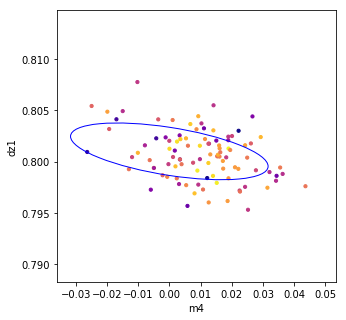

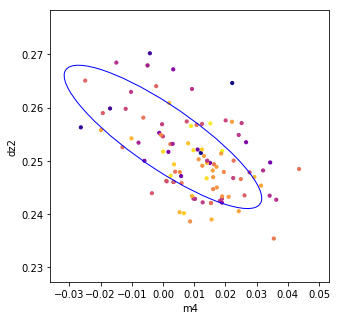

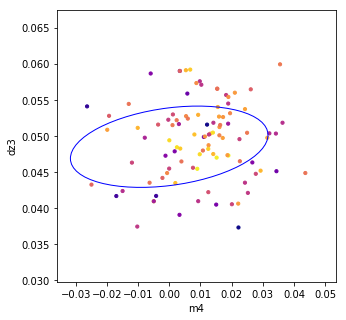

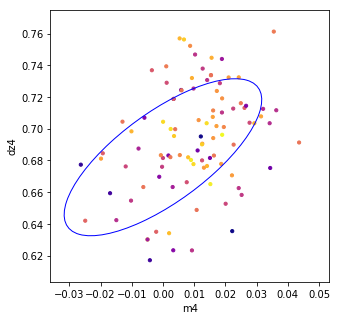

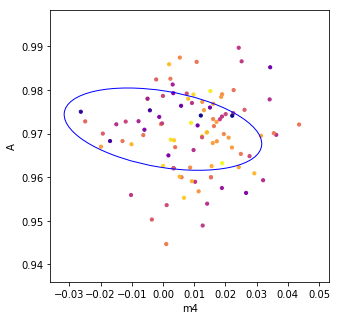

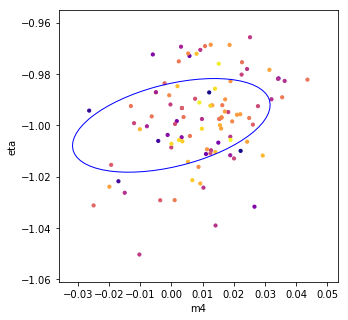

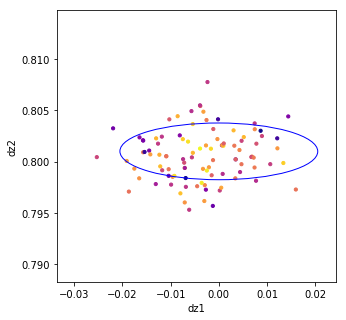

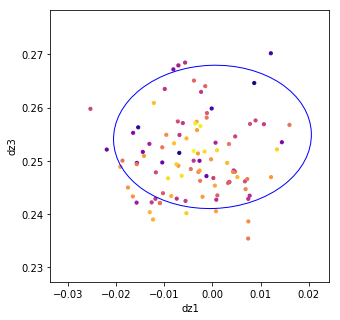

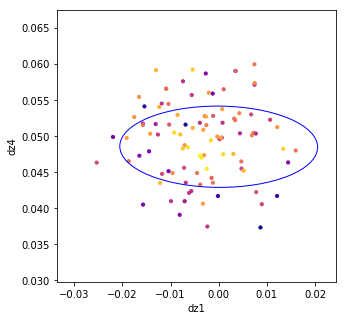

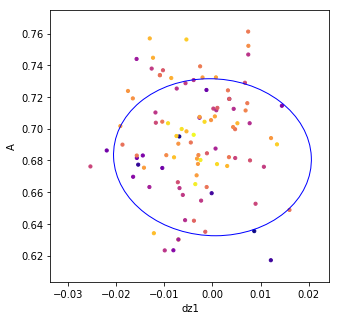

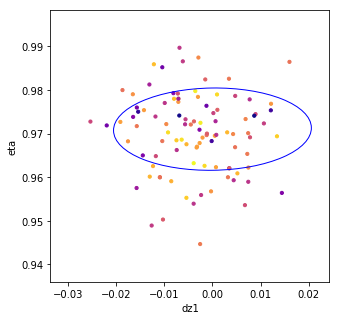

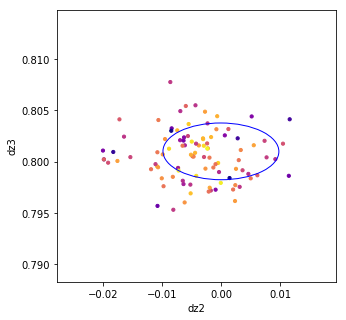

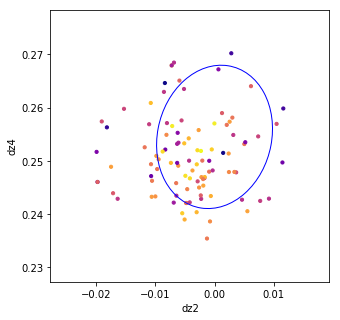

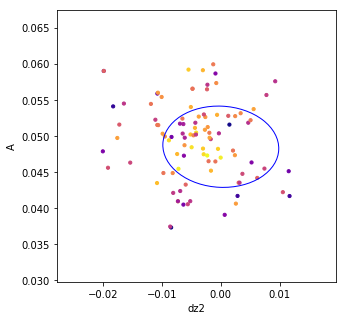

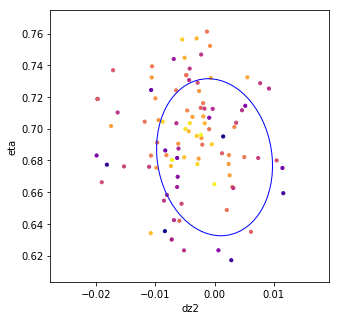

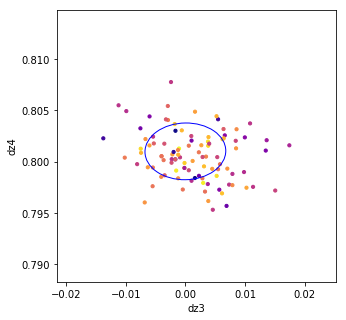

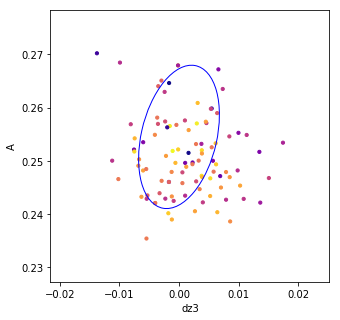

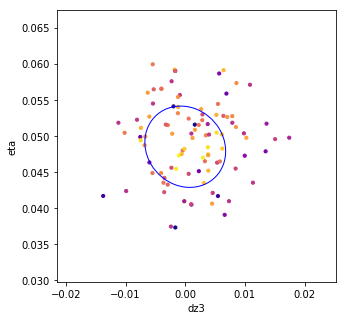

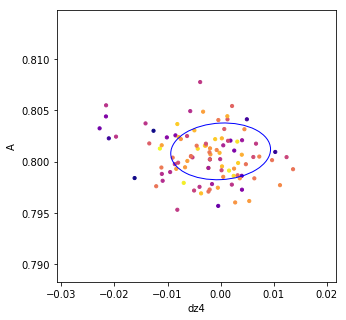

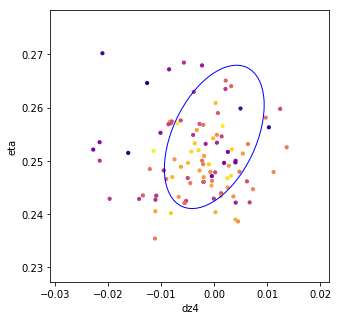

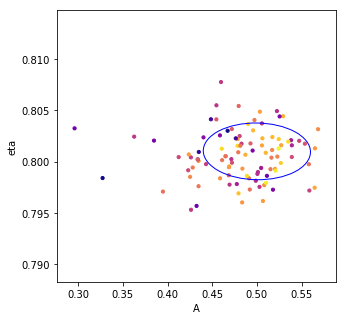

In [95]:
for i, name1 in enumerate(names[:]):
    for j, name2 in enumerate(names[i+1:]):
        figure(figsize=(5,5))
        chain = onp.array(sampler.trace)
        plt.scatter(chain[:, i], chain[:, j], s=10, c=sampler.trace_logP, cmap='plasma')
        plot_contours(F, fid_params, i, j, facecolor='None', edgecolor='b')
        xlabel(name1)
        ylabel(name2)

# Expand for many plots